In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.tools

import pandas as pd
import numpy as np

plotly.tools.set_credentials_file(username='aggittle', api_key='s7oM3A2McD0WjOeYpHQ0')

pd.options.display.max_columns = None

In [3]:
# Make train set from first 750 rows of each genre csv, test set with remaining rows

csvs = ['reggae' ,'jazz', 'rock', 'dance', 'classical', 'rap']
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version']
spotifydf = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0) for csv in csvs], sort=True).drop(drops, axis =1)
            .drop_duplicates(subset=['name','track']))
spotify_train_names = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0)[:750] for csv in csvs], sort=True).drop(drops, axis =1)
                      .drop_duplicates(subset=['name','track']))
spotify_test_names = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0)[750:] for csv in csvs], sort=True).drop(drops, axis =1)
                     .drop_duplicates(subset=['name','track']))

spotify_train = spotify_train_names.drop(['name', 'track'], axis=1)
spotify_test = spotify_test_names.drop(['name', 'track'], axis=1)

X_train, y_train, X_test, y_test = spotify_train.drop('genre', axis=1), spotify_train.genre, spotify_test.drop('genre', axis=1), spotify_test.genre

## EDA

In [3]:
spotifydf.columns

Index(['acousticness', 'danceability', 'duration', 'duration_ms',
       'end_of_fade_in', 'energy', 'genre', 'instrumentalness', 'key',
       'key_confidence', 'liveness', 'loudness', 'mode', 'mode_confidence',
       'name', 'num_samples', 'speechiness', 'start_of_fade_out', 'tempo',
       'tempo_confidence', 'time_signature', 'time_signature_confidence',
       'track', 'valence'],
      dtype='object')

In [4]:
genre_counts = spotifydf.groupby('genre')['mode'].count()

In [5]:
genre_counts

genre
classical    1106
dance        1031
jazz         1012
rap          1075
reggae       1120
rock         1038
Name: mode, dtype: int64

Total counts for each genre in entire dataset:

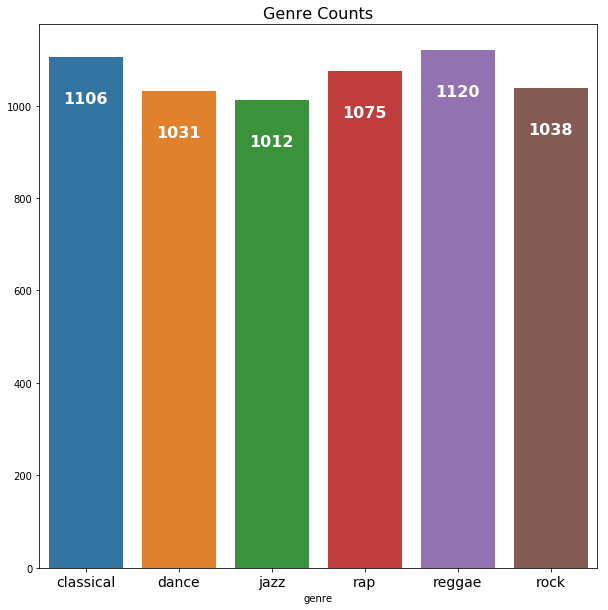

In [6]:
plt.figure(figsize=(10,10))
plt.title('Genre Counts', size=16)
plt.xticks(size=14)


g = sns.barplot(genre_counts.index, genre_counts.values);

for index, row in enumerate(genre_counts):
     g.text(index, row-100, row, color='white', ha="center", size='16', weight='bold')

plt.show()

In [33]:
classical = spotifydf[(spotifydf.genre=='classical')]
dance = spotifydf[(spotifydf.genre=='dance')]
jazz = spotifydf[(spotifydf.genre=='jazz')]
rap = spotifydf[(spotifydf.genre=='rap')]
reggae = spotifydf[(spotifydf.genre=='reggae')]
rock = spotifydf[(spotifydf.genre=='rock')]

In [34]:
def get_dist_plot(feature):
    plt.figure(figsize=(12,10))
    sns.distplot(classical[feature], label='classical', hist=False, kde_kws={"shade": True})
    sns.distplot(dance[feature], label='dance', hist=False, kde_kws={"shade": True})
    sns.distplot(jazz[feature], label='jazz', hist=False, kde_kws={"shade": True})
    sns.distplot(rap[feature], label='rap', hist=False, kde_kws={"shade": True})
    sns.distplot(reggae[feature], label='reggae', hist=False, kde_kws={"shade": True})
    sns.distplot(rock[feature], label='rock', hist=False, kde_kws={"shade": True})
    plt.legend(loc='upper right', fontsize=17)
    plt.title(feature.capitalize(), size=32)

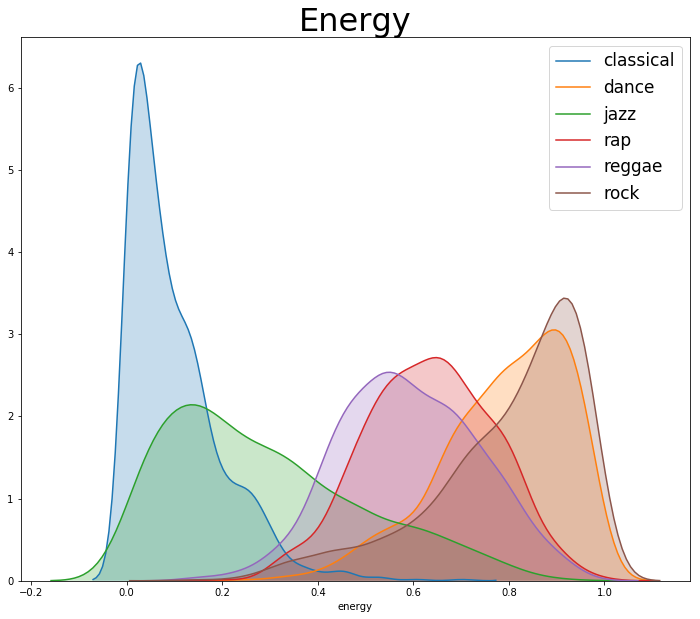

In [9]:
get_dist_plot('energy')
#plt.savefig('energy')

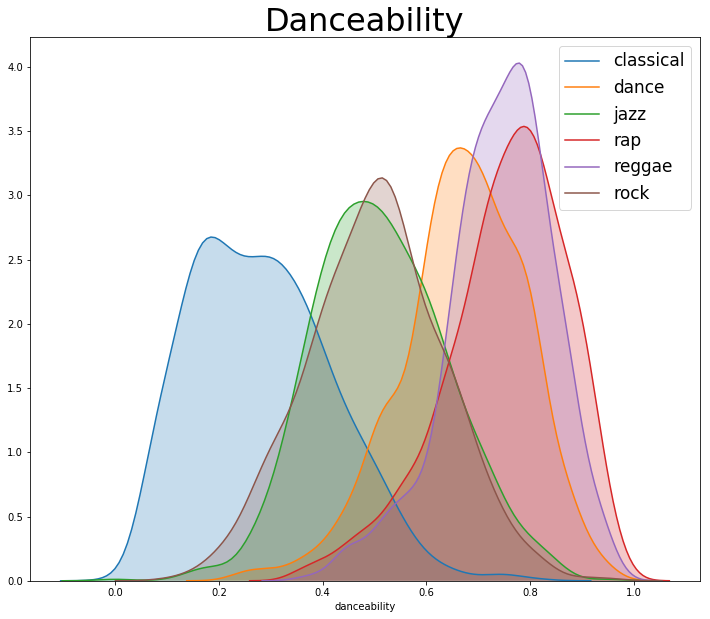

In [10]:
get_dist_plot('danceability')
#plt.savefig('danceability')

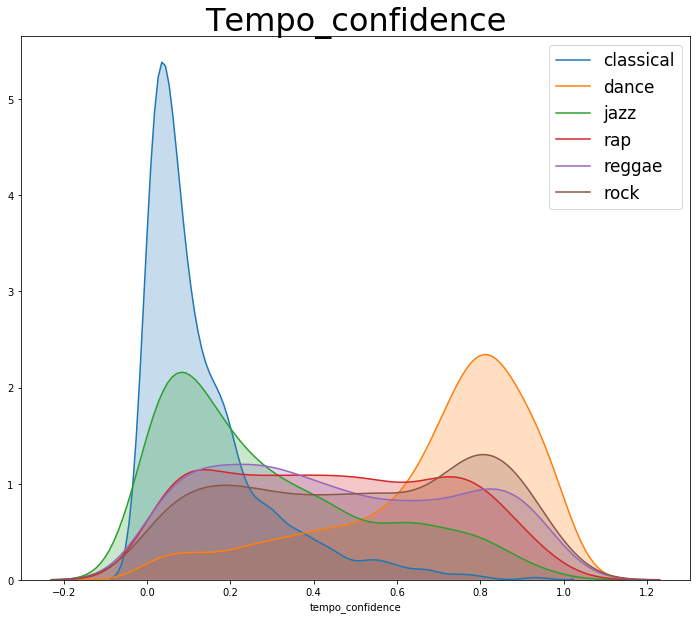

In [11]:
get_dist_plot('tempo_confidence')
#plt.savefig('tempo_confidence')

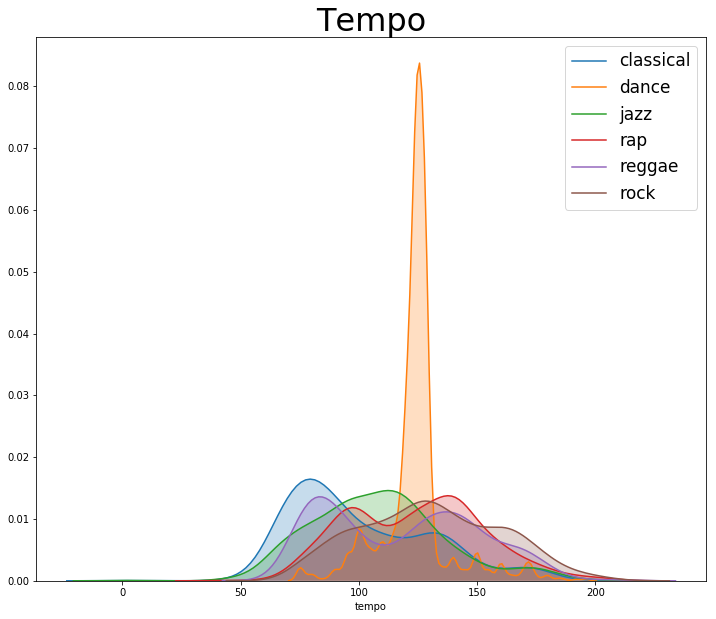

In [12]:
get_dist_plot('tempo')

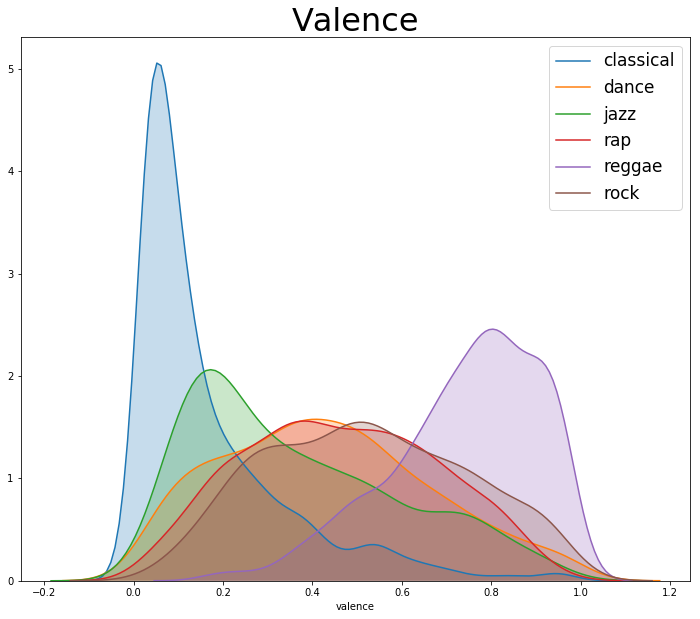

In [35]:
get_dist_plot('valence')
plt.savefig('valence.png')

#### Create 3D scatter plot (Energy, Danceability, Tempo-confidence)

In [29]:
data = []
clusters = []
colors = ['rgba(151, 48, 155, 0.75)','rgba(80, 155, 48, 0.75)','rgba(145, 87, 52, 0.75)', 'rgba(252, 165, 25, 0.75)', 'rgba(25, 115, 252, 0.75)', 'rgba(252, 25, 25, 0.75)'] # set our dot colors

name = 'eye = (x:0, y:0, z:0.1)'
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=0.1)
)
for i in range(len(spotifydf['genre'].unique())): # allows us to split our data into three distinct groups
    name = spotifydf['genre'].unique()[i]
    color = colors[i]
    x = spotifydf[ spotifydf['genre'] == name ]['energy']
    y = spotifydf[ spotifydf['genre'] == name ]['danceability']
    z = spotifydf[ spotifydf['genre'] == name ]['tempo_confidence']
    
    trace = dict(  # trace is how we "trace" or draw our data on the canvas
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

layout = dict( # we modify our canvas here, including initial layout and styles
    width=800,
    height=550,
    autosize=False,
    title='Spotify Songs',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Energy',  # set titles, very important
            titlefont=dict(
            family='Arial Black',
            size=14,
            color='#2f2f2f'),  # we can use hex, rgba, or other color variants
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Danceability',  # set titles, very important
            titlefont=dict(
            family='Arial Black',
            size=14,
            color='#4f4f4f'),
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Tempo Confidence',  # set titles, very important
            titlefont=dict(
            family='Arial Black',
            size=14,
            color='#7f7f7f'),
        ),
        aspectratio = dict( x=1, y=1, z=1 ), # we can compress large dimensions this way
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout) # this finally compiles our figure

# run locally in notebook
py.iplot(fig, filename='pandas-3d-iris', validate=False)

# run on site, may need an account and access key, depending on usage
url = py.plot(fig, filename=name, validate=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



####  Create 3D scatter plot (Energy, Danceability, Valence)

In [36]:
data = []
clusters = []
colors = ['rgba(151, 48, 155, 0.75)','rgba(80, 155, 48, 0.75)','rgba(145, 87, 52, 0.75)', 'rgba(252, 165, 25, 0.75)', 'rgba(25, 115, 252, 0.75)', 'rgba(252, 25, 25, 0.75)'] # set our dot colors

name = 'eye = (x:0, y:0, z:0.1)'
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=0.1)
)
for i in range(len(spotifydf['genre'].unique())): # allows us to split our data into three distinct groups
    name = spotifydf['genre'].unique()[i]
    color = colors[i]
    x = spotifydf[ spotifydf['genre'] == name ]['energy']
    y = spotifydf[ spotifydf['genre'] == name ]['danceability']
    z = spotifydf[ spotifydf['genre'] == name ]['valence']
    
    trace = dict(  # trace is how we "trace" or draw our data on the canvas
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

layout = dict( # we modify our canvas here, including initial layout and styles
    width=800,
    height=550,
    autosize=False,
    title='Spotify Songs',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Energy',  # set titles, very important
            titlefont=dict(
            family='Arial Black',
            size=14,
            color='#2f2f2f'),  # we can use hex, rgba, or other color variants
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Danceability',  # set titles, very important
            titlefont=dict(
            family='Arial Black',
            size=14,
            color='#4f4f4f'),
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Valence',  # set titles, very important
            titlefont=dict(
            family='Arial Black',
            size=14,
            color='#7f7f7f'),
        ),
        aspectratio = dict( x=1, y=1, z=1 ), # we can compress large dimensions this way
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout) # this finally compiles our figure

# run locally in notebook
py.iplot(fig, filename='pandas-3d-iris', validate=False)

# run on site, may need an account and access key, depending on usage
url = py.plot(fig, filename=name, validate=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Classification 1: Logit and KNN, all features

Without doing anything to the data, I just threw it at some models to see what would happen.

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("The score for kNN is")
print("Training: {}%".format(100*knn.score(X_train, y_train)))
print("Test set: {}%".format(100*knn.score(X_test, y_test)))

The score for kNN is
Training: 48.51951547779273%
Test set: 25.557809330628807%


In [17]:
logit = LogisticRegression(C = 0.95 )
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

The score for logistic regression is
Training:  16.80%
Test set:  18.26%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [18]:
labels = ['classical','dance', 'jazz', 'rap', 'reggae', 'rock']
conf_matrix = confusion_matrix(y_test, knn.predict(X_test), labels=labels)

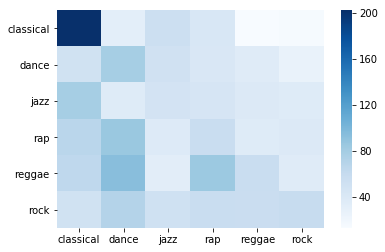

In [19]:
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels)

In [20]:
#sns.pairplot(spotify_test, hue='genre')

Not great. Many of the features, such as  key, key confidence, mode, mode confidence, completely overlap. This makes sense- music of any genre can be played in any key. While there are certainly more popular and less popular keys (C is easy on piano, G is easy on guitar), it makes sense that it wouldn't be a useful feature for classification. 


# Classification 2: Only a few features

In [21]:

drops = ['offset_seconds', 'window_seconds', 'analysis_sample_rate', 'analysis_channels', 'code_version',
         'echoprint_version', 'synch_version', 'rhythm_version', 'acousticness',
         'duration', 'duration_ms',
         'end_of_fade_in', 'instrumentalness', 'key',
         'key_confidence', 'liveness', 'loudness', 'mode', 'mode_confidence',
         'num_samples', 'speechiness', 'start_of_fade_out', 'tempo',
         'time_signature', 'time_signature_confidence',
         'valence']

spotifydf = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0) for csv in csvs], sort=True).drop(drops, axis=1)
             .drop_duplicates(subset=['name', 'track']))
spotify_train_names = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0)[:750] for csv in csvs], sort=True).drop(drops, axis=1)
                       .drop_duplicates(subset=['name', 'track']))
spotify_test_names = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0)[750:] for csv in csvs], sort=True).drop(drops, axis=1)
                      .drop_duplicates(subset=['name', 'track']))

spotify_train = spotify_train_names.drop(['name', 'track'], axis=1)
spotify_test = spotify_test_names.drop(['name', 'track'], axis=1)

X_train, y_train, X_test, y_test = spotify_train.drop(
    'genre', axis=1), spotify_train.genre, spotify_test.drop('genre', axis=1), spotify_test.genre

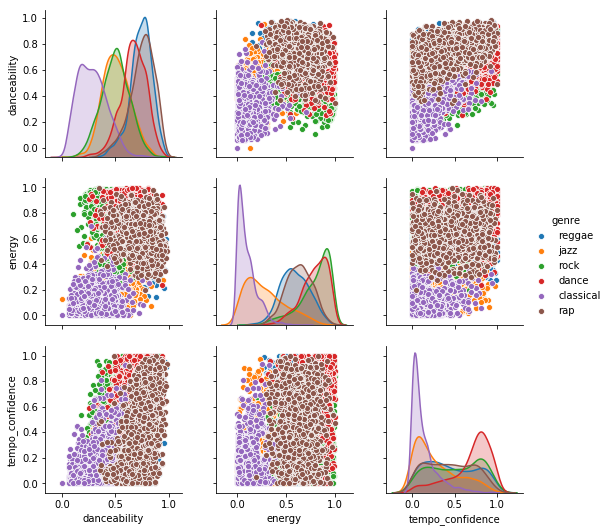

In [22]:
sns.pairplot(spotifydf, hue='genre')

In [23]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("KNN")
print(f"Training: {knn.score(X_train, y_train)}")
print(f"Test: {knn.score(X_test, y_test)}")

KNN
Training: 0.6895468820098699
Test: 0.5730223123732252


In [24]:
logit = LogisticRegression(C = 0.95, solver='liblinear', multi_class='ovr')
logit.fit(X_train, y_train)
print("Logistic Regression")
print(f"Training: {logit.score(X_train, y_train)}")
print(f"Test: {logit.score(X_test, y_test)}")

Logistic Regression
Training: 0.5769403319874383
Test: 0.5907707910750507


In [25]:
tree = DecisionTreeClassifier(max_depth=11)
tree.fit(X_train, y_train)
print("Decision Tree")
print(f"Training: {tree.score(X_train, y_train)}")
print(f"Test: {tree.score(X_test, y_test)}")

Decision Tree
Training: 0.7907133243606999
Test: 0.5552738336713996


# Classification 3: Logit, KNN, Naive Bayes, Decision Tree, Forest (useful features)

Let's drop some more features:

In [26]:
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode']

spotifydf = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0) for csv in csvs], sort=True).drop(drops, axis =1)
            .drop_duplicates(subset=['name','track']))
spotify_train_names = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0)[:750] for csv in csvs], sort=True).drop(drops, axis =1)
                      .drop_duplicates(subset=['name','track']))
spotify_test_names = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0)[750:] for csv in csvs], sort=True).drop(drops, axis =1)
                     .drop_duplicates(subset=['name','track']))

spotify_train = spotify_train_names.drop(['name', 'track'], axis=1)
spotify_test = spotify_test_names.drop(['name', 'track'], axis=1)

X_train, y_train, X_test, y_test = spotify_train.drop('genre', axis=1), spotify_train.genre, spotify_test.drop('genre', axis=1), spotify_test.genre


In [27]:
#sns.pairplot(spotify_test, hue='genre')

In [28]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("KNN")
print(f"Training: {knn.score(X_train, y_train)}")
print(f"Test: {knn.score(X_test, y_test)}")

KNN
Training: 0.6467025572005384
Test: 0.43762677484787016


In [29]:
logit = LogisticRegression(C = 0.95, solver='liblinear', multi_class='ovr')
logit.fit(X_train, y_train)
print("Logistic Regression")
print(f"Training: {logit.score(X_train, y_train)}")
print(f"Test: {logit.score(X_test, y_test)}")

Logistic Regression
Training: 0.7528039479587258
Test: 0.7195740365111561


In [30]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print("Naive Bayes")
print(f"Training: {nb.score(X_train, y_train)}")
print(f"Test: {nb.score(X_test, y_test)}")

Naive Bayes
Training: 0.7169134140870346
Test: 0.6937119675456389


In [31]:
#svm = SVC(kernel='poly', degree=2, gamma='auto')
#svm.fit(X_train, y_train)
#print("SVC")
#print(f"Training: {svm.score(X_train, y_train)}")
#print(f"Test: {svm.score(X_test, y_test)}")

In [32]:
tree = DecisionTreeClassifier(max_depth=11)
tree.fit(X_train, y_train)
print("Decision Tree")
print(f"Training: {tree.score(X_train, y_train)}")
print(f"Test: {tree.score(X_test, y_test)}")

Decision Tree
Training: 0.9297891431135038
Test: 0.6982758620689655


In [33]:
forest = RandomForestClassifier(n_estimators=500, max_depth = 50)
forest.fit(X_train, y_train)
print("Random Forest")
print(f"Training: {forest.score(X_train, y_train)}")
print(f"Test: {forest.score(X_test, y_test)}")

Random Forest
Training: 1.0
Test: 0.8002028397565923


In [34]:
print('Metrics for Random Forest:')
print(labels)
p = precision_score(y_test, forest.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, forest.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, forest.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Random Forest:
['classical', 'dance', 'jazz', 'rap', 'reggae', 'rock']
Precision: [0.94842407 0.72916667 0.77241379 0.7375     0.75862069 0.8362069 ],
 Recall: [0.91944444 0.73684211 0.78596491 0.72615385 0.77297297 0.83861671],
 F1: [0.93370945 0.73298429 0.77913043 0.73178295 0.76572959 0.83741007]


[[331   0  29   0   0   0]
 [  0 210   5  28  16  26]
 [ 18   3 224   3  22  15]
 [  0  40   5 236  36   8]
 [  0   8  15  53 286   8]
 [  0  27  12   0  17 291]]


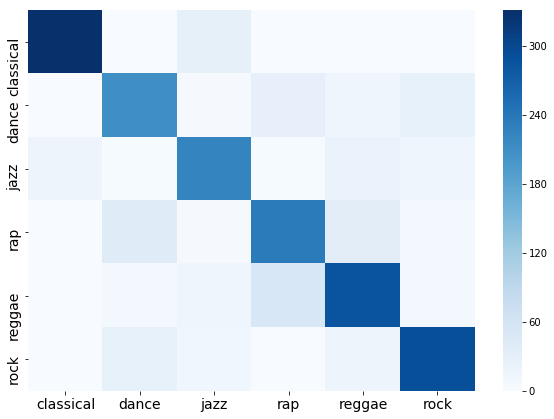

In [35]:
conf_matrix =  confusion_matrix(y_test, forest.predict(X_test), labels=labels);
print(conf_matrix)
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels);

#### Classical music is the easiest for the Random Forest model to classify, only getting mis-classified as jazz in some cases. 

# Classification 4: Random Forest + Gradient Boost, Feature Importance

In [4]:
# Use train_test_split to split data this time

drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode']

spotifydf = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0) for csv in csvs], sort=True).drop(drops, axis =1)
            .drop_duplicates(subset=['name','track']))

labels = ['classical','dance', 'jazz', 'rap', 'reggae', 'rock']

X = spotifydf.drop('genre',axis=1)
y = spotifydf.genre

X_train, X_test_names, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
X_train_names, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=25)

X_test = X_test_names.drop(['name','track'],axis=1)
X_train = X_train_names.drop(['name','track'],axis=1)
X_val = X_val.drop(['name','track'],axis=1)

In [45]:
len(spotifydf)

6382

In [40]:
spotifydf.columns

Index(['acousticness', 'danceability', 'end_of_fade_in', 'energy', 'genre',
       'instrumentalness', 'liveness', 'loudness', 'name', 'speechiness',
       'start_of_fade_out', 'tempo', 'tempo_confidence', 'time_signature',
       'time_signature_confidence', 'track', 'valence'],
      dtype='object')

In [5]:
forest = RandomForestClassifier(n_estimators=500, max_depth = 50)
forest.fit(X_train, y_train)
print("Random Forest")
print(f"Training: {forest.score(X_train, y_train)}")
print(f"Test: {forest.score(X_test, y_test)}")

Random Forest
Training: 1.0
Test: 0.8026624902114331


In [6]:
print('Metrics for Random Forest:')
print(labels)
p = precision_score(y_test, forest.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, forest.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, forest.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Random Forest:
['classical', 'dance', 'jazz', 'rap', 'reggae', 'rock']
Precision: [0.90454545 0.78010471 0.80676329 0.82648402 0.75619835 0.73737374],
 Recall: [0.8963964  0.73399015 0.76958525 0.81900452 0.82432432 0.76041667],
 F1: [0.90045249 0.75634518 0.78773585 0.82272727 0.7887931  0.74871795]


In [11]:
feature_importances = sorted(list(zip(forest.feature_importances_, X_train.columns)), reverse = True)

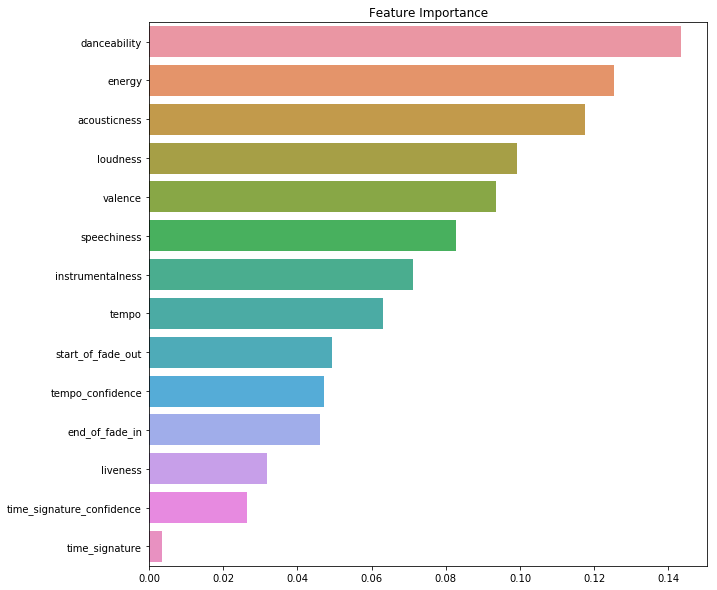

In [22]:
x = [f[0] for f in feature_importances]
y = [f[1] for f in feature_importances]
plt.figure(figsize=(10,10));
sns.barplot(x, y);
plt.title('Feature Importance');

In [14]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=9,
                        objective='multi:softmax', 
                        num_class=6,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma = .5
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss',
                    early_stopping_rounds=1000,
                    verbose=False
                   )

accuracy_score(y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

0.8183241973375098

In [15]:
print('Metrics for Gradient Boost:')
print(labels)
p = precision_score(y_test, gbm.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, gbm.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, gbm.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Gradient Boost:
['classical', 'dance', 'jazz', 'rap', 'reggae', 'rock']
Precision: [0.92237443 0.78712871 0.8277512  0.8411215  0.76446281 0.76439791],
 Recall: [0.90990991 0.78325123 0.79723502 0.81447964 0.83333333 0.76041667],
 F1: [0.91609977 0.78518519 0.81220657 0.82758621 0.79741379 0.76240209]


In [23]:
metricsdf = pd.DataFrame([p,r,f1], index= ['precision','recall','f1'], columns=labels)

In [26]:
metricsdf

,classical,dance,jazz,rap,reggae,rock
precision,0.922374,0.787129,0.827751,0.841121,0.764463,0.764398
recall,0.909910,0.783251,0.797235,0.814480,0.833333,0.760417
f1,0.916100,0.785185,0.812207,0.827586,0.797414,0.762402


[[202   0  20   0   0   0]
 [  0 159   2  17   4  21]
 [ 17   4 173   1   8  14]
 [  0  10   1 180  28   2]
 [  0   7   9  13 185   8]
 [  0  22   4   3  17 146]]


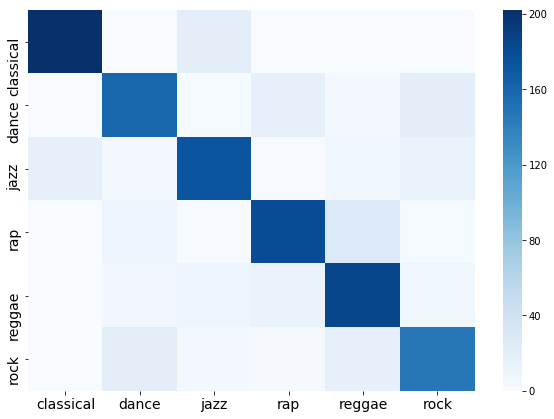

In [16]:
conf_matrix =  confusion_matrix(y_test, gbm.predict(X_test), labels=labels);
print(conf_matrix)
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels);

### Let's check out some rock songs that were predicted as dance, and vice-versa. We'll also look at rap and reggae confusion.

In [17]:
X_test_names['predictions'] = gbm.predict(X_test)
X_test_names['genre'] = y_test

In [18]:
X_test_names[(X_test_names.genre=='rock')&
            (X_test_names.predictions=='dance')][['name','track','genre','predictions']]

,name,track,genre,predictions
643,Mikey Mike,Cooler,rock,dance
262,Rise Of The Northstar,Here Comes The Boom,rock,dance
8,AC/DC,Highway to Hell,rock,dance
429,Deftones,Hearts / Wires,rock,dance
637,The Record Company,Life To Fix - Radio Edit,rock,dance
1051,The Raconteurs,"Steady, As She Goes",rock,dance
763,Sublime,Santeria,rock,dance
846,Nine Inch Nails,The Hand That Feeds,rock,dance
35,Bob Seger,Old Time Rock & Roll,rock,dance
52,David Bowie,Rebel Rebel - 1999 Remastered Version,rock,dance


In [19]:
X_test_names[(X_test_names.genre=='dance')&
            (X_test_names.predictions=='rock')][['name','track','genre','predictions']]

,name,track,genre,predictions
403,ماجد ككا,حبيبتي الى متى,dance,rock
877,Danny Avila,Too Good to Be True,dance,rock
534,Darude,Timeless,dance,rock
195,Ritviz,Barso,dance,rock
12,Martin Garrix,High On Life (feat. Bonn),dance,rock
705,KSUKE,Favorite Mistake (feat. Sidnie Tipton),dance,rock
182,When Pandas Attack,Beautiful,dance,rock
477,Lost Sky,Dreams pt. II,dance,rock
966,James Blake,Can't Believe The Way We Flow,dance,rock
138,AERODRAZE,Let Me Try (feat. Valeria Interdonato),dance,rock


In [20]:
X_test_names[(X_test_names.genre=='rap')&
            (X_test_names.predictions=='reggae')][['name','track','genre','predictions']]

,name,track,genre,predictions
544,G-Eazy,1942,rap,reggae
890,Sky,Bajo Cero,rap,reggae
862,Hungria Hip Hop,Copo pro Alto,rap,reggae
216,Stefflon Don,Hurtin' Me,rap,reggae
153,Gemitaiz,Rollin',rap,reggae
638,The Notorious B.I.G.,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,rap,reggae
240,Zoda,Balla,rap,reggae
627,Ice Cube,It Was A Good Day,rap,reggae
839,Adi Nowak,Placebo,rap,reggae
624,Various Artists,Big Poppa,rap,reggae


In [21]:
X_test_names[(X_test_names.genre=='reggae')&
            (X_test_names.predictions=='rap')][['name','track','genre','predictions']]

,name,track,genre,predictions
348,Biga Ranx,"Monday (feat. LEJ, Akhenaton & Blundetto)",reggae,rap
1069,Stephen Marley,"Rock Stone (feat. Capleton, Sizzla)",reggae,rap
580,Popcaan,Through The Storm,reggae,rap
1317,Ini Kamoze,World - a - Music - Remastered,reggae,rap
436,Vibrações,Pretinha Minha,reggae,rap
320,Volodia,La meme passion,reggae,rap
416,Marina Peralta,Mama Respect,reggae,rap
516,Various Artists,Good Boy,reggae,rap
90,Rorystonelove,Not Because,reggae,rap
1183,Buju Banton,Driver A,reggae,rap


We're using Spotify playlists as our data source, and we can see that there are some loose interpretations of some of these genres in the playlists. The confusion our model sees in thinking reggae songs are rap makes sense, as some of the artists bridge the gap between the two genres. 

# Cross-validate on whole data set (Random Forest):

In [ ]:
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode', 'name','track']
spotifydf = (pd.concat([pd.read_csv(f'csvs/{csv}.csv', index_col=0) for csv in csvs], sort=True).drop_duplicates(subset=['name','track']).drop(drops, axis =1)
            )

In [ ]:
forest = RandomForestClassifier(n_estimators=200)


cv_scores = cross_val_score(forest, spotifydf.drop('genre',axis=1), spotifydf.genre, cv=10)

In [ ]:
cv_scores

In [ ]:
np.mean(cv_scores)

Not too much difference here than Classification 3. 

# Stratified Cross-validation with XGBoost 

In [43]:
skf = StratifiedKFold(n_splits=5, random_state=4444, shuffle=False)

In [44]:
cv_rf = [] 
for train_ind, val_ind in skf.split(X,y):
    
    X_train, y_train = X.drop(['name','track'],axis=1).iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.drop(['name','track'],axis=1).iloc[val_ind], y.iloc[val_ind] 
    
    
    gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=8,
                        objective='multi:softmax', 
                        num_class=6,
                        learning_rate=.2, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma = .5
                       )

    eval_set=[(X_train,y_train),(X_val,y_val)]
    fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=1000,
                    verbose=False
                   )
    

   
    cv_rf.append(fit_model.score(X_val, y_val))
    
   



In [45]:
np.mean(cv_rf)

0.7992576914746182

In [46]:
cv_rf

[0.8420641125879593,
 0.793265465935787,
 0.7774294670846394,
 0.807843137254902,
 0.7756862745098039]

# Story:

Spotify recommends music with content-agnostic methods. It's tougher for new songs to be recommended this way. Can we recommend songs based on audio analysis to build a better recommender?

We can use the differences and similarities in the genres to make recommendations that span multiple genres with like characteristics. For example, classical and jazz , rap and reggae, and dance and rock are some examples of genre pairs of which a listener of one may like the other. Upon deeper investigation, we see the subgenres of certain genres like dance (House, trance, drum and bass) ae distinct from one another, while other related genres like country, folk, and blues are less easily discernable. The recommender can strongly assume a fan of country music will also like folk, but can less strongly recommend drum and bass to house music fans.

Instead of trying to classify hundreds of sub-genres with one model, we can do some manual decision tree work based on some domain knowledge; after classifying a song with a broad genre label, we can funnel it into a  different model that classifies the song into its sub-genre. SEE SPOTIFY CLASSIFICATION 2.